# Init 

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from tqdm import tqdm_notebook


# Utils 

In [2]:
IMAGE_SIZE = (256, 128)
TEXT_SIZE = 64

def load_fonts(folder, num_fonts=5, search_format='*.ttf', return_labels=True):
    if folder[-1] != '/':
        folder += '/'
        
    font_files = np.array(glob.glob(f'{folder}{search_format}'))
    
    if num_fonts >= 0:
        rand_idx = np.random.randint(0, len(font_files), size=num_fonts)
        rand_fonts = font_files[rand_idx]
    else:
        rand_fonts = font_files
    
    get_file_name = lambda x: os.path.split(x)[-1][:-4]
    labels = [get_file_name(file) for file in rand_fonts]
    
    if return_labels:
        return list(rand_fonts), labels
    else:
        return list(rand_fonts)

def write_text_on_the_image(text, font, image_size=None, font_size=TEXT_SIZE):
    if image_size is None:
        image_size = (48 * len(text) + 32, 80)
    
    img = Image.new('RGB', image_size, color='white')

    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font, TEXT_SIZE)

    # draw.text((x, y),"Sample Text",(r,g,b))
    draw.text((0, 0), text, (0, 0, 0), font=font)
    return img.convert('L')

def load_words(file_path, num_words=1000):
    with open(file_path) as word_file:
        valid_words = list(word_file.read().split())
        
    if num_words >= 0:
        rand_idx = np.random.randint(0, len(valid_words), size=num_words)
        valid_words = np.array(valid_words)[rand_idx]
    else:
        return valid_words

    return list(valid_words)

def invert_image(img:'np.array'):
    return np.abs(255-img)

def create_images(words, fonts, font_names, return_numpy_array=False, inverse_image=False, resize_image_shape=(80, 500)):
    from scipy.misc import imresize
    images, labels = [], []
    for font, label in tqdm_notebook(zip(fonts, font_names), total=len(fonts)):
        for word in words:
            image = write_text_on_the_image(word, font)
            images.append(image)
            labels.append(label)
    
    if return_numpy_array:
        images = [np.asarray(image) for image in images]
        
        if inverse_image:
            images = [invert_image(image) for image in images]
            
    if resize_image_shape is not None:
        images = [imresize(image, resize_image_shape) for image in images]
        
    
    return images, labels

def pickle_save(obj, file):
    import pickle
    with open(file, 'wb') as f:
        pickle.dump(obj, f)
        
def pickle_load(file):
    import pickle
    with open(file, 'rb') as f:
        return pickle.load(f)
    
def now(format_="%Y-%m-%d %H:%M"):
    from datetime import datetime
    return datetime.now().strftime(format_)

def purge_directory(directory):
    import shutil
    import os
    if directory[0] == '/':
        raise Exception('check the dir boy')
    try:
        shutil.rmtree(directory)
    except FileNotFoundError:
        pass
    
    os.mkdir(directory)

# Data Load

In [3]:
words = load_words('./words_alpha.txt', num_words=10**3)
fonts, labels = load_fonts('./_fonts', num_fonts=5)

images, labels = create_images(words, fonts, labels, return_numpy_array=True, inverse_image=True, resize_image_shape=(80, 500))

C:\Anaconda3\envs\update_1\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [4]:
pickle_save([images, labels], 'dataset.tpl')

ARHERMANN


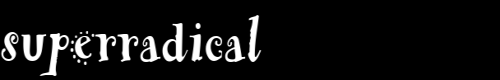

In [56]:
rand = np.random.randint(0, len(images), size=1)[0]
print(labels[rand])

Image.fromarray(images[rand])

# Transfer learning

## Data prep

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

data = pickle_load('dataset.tpl')
images, labels = data

label_enc = LabelEncoder()
labels_encoded = label_enc.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded, num_classes=5)

images = np.array(images)
images = np.expand_dims(images, -1) #for gray
# images = np.squeeze(np.stack([images] * 3, axis=-1))
# images = images.astype(np.float32) / 255

X_train, X_test, y_train, y_test = train_test_split(images, labels_onehot, stratify=labels, test_size=.1, shuffle=True)

print("Train size:", X_train.shape, '\nTarget shape:', y_train.shape)

Using TensorFlow backend.


Train size: (4500, 80, 500, 1) 
Target shape: (4500, 5)


## Image gen 

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split=.1,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255,
) # zca?

datagen.fit(X_train)

In [14]:
import keras.backend as K

from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint

from keras_cyclic_lr import CyclicLR
from keras_lr_finder import LRFinder

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

K.clear_session()

NAME = 'Xception'
BATCH_SIZE = 64

base_model = Xception(include_top=False, input_shape=(80, 500, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)

predictions = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:-2]:
    layer.trainable = False
    
for layer in model.layers[-2:]:
    layer.trainable = True
    
optimizers = dict(
    adam=Adam(lr=3e-4, decay=0),
    sgd=SGD(lr=1e-2, momentum=0.95, nesterov=True),
)
    
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers['adam'], 
    metrics=["accuracy"],
)

tb_log_dir = './tb_logs/{}/{}'.format(NAME, now("%Y-%m-%d %H_%M"))
save_path = './_checkpoints/'

purge_directory(save_path)

callbacks = [
    TQDMNotebookCallback(),
    TensorBoard(log_dir=tb_log_dir, write_graph=False),
#     ModelCheckpoint(save_path + 'checkpoint-{epoch:02d}-{val_loss:.4f}.mdl', monitor='val_loss', save_best_only=True),
    CyclicLR(base_lr=1e-3, max_lr=1e-2, step_size=2000),
#     OneCycleLR(max_lr=1e-3, verbose=False)
]

# training_gen = datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE, subset='training')

# validation_gen = datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE, subset='validation')

# model.fit_generator(
#     training_gen,
#     steps_per_epoch=len(X_train) // BATCH_SIZE,
    
#     validation_data=validation_gen, 
#     validation_steps=int(len(X_train) * .1 // BATCH_SIZE),
    
#     epochs=5, 
#     verbose=0, 
#     callbacks=callbacks,
# )

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=12, validation_split=.1, verbose=0, callbacks=callbacks)

Using GPU


KeyboardInterrupt: 

## Inference

In [45]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255) # zca?

datagen.fit(X_test)

In [46]:
model.evaluate_generator(datagen.flow(X_test, y_test, batch_size=BATCH_SIZE), steps=len(X_test) // BATCH_SIZE)

[4.642346890767415, 0.2]

In [63]:
model.evaluate(X_test, y_test)

500/500 [==============================] - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 23s 47ms/step


[2.232809736251831, 0.20600000023841858]

## LR Finder

In [12]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

if X_train_rescale is not None:
    X_train_rescale = X_train.astype(float) * 1/255

lr_finder.find(X_train_rescale, y_train, start_lr=1e-6, end_lr=5, batch_size=BATCH_SIZE, epochs=1, verbose=0, callbacks=[TQDMNotebookCallback()])

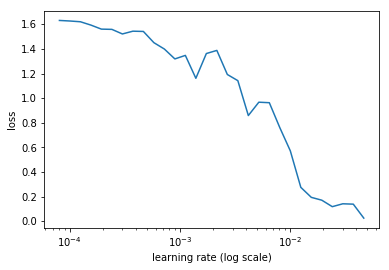

In [13]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

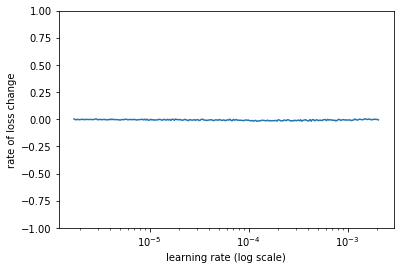

In [136]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-1, 1))

# Small convnet

In [25]:
import keras.backend as K

from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint

from keras_cyclic_lr import CyclicLR
from keras_lr_finder import LRFinder

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    print('Using GPU')

K.clear_session()

NAME = 'SmallConv'
BATCH_SIZE = 16

model = Sequential([
    Conv2D(8, kernel_size=(3, 3),
                 activation='elu',
                 input_shape=(80, 500, 1)),
    Conv2D(16, (3, 3), activation='elu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation='elu'),
    Dropout(0.5),
    Dense(5, activation='softmax'),
])

optimizers = dict(
    adam=Adam(lr=3e-4, decay=0),
    sgd=SGD(lr=1e-2, momentum=0.95, nesterov=True),
)

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers['adam'], 
    metrics=["accuracy"],
)

tb_log_dir = './tb_logs/{}/{}'.format(NAME, now("%Y-%m-%d %H_%M"))
save_path = './_checkpoints/'

purge_directory(save_path)

callbacks = [
    TQDMNotebookCallback(),
    TensorBoard(log_dir=tb_log_dir, write_graph=False),
    CyclicLR(base_lr=1e-6, max_lr=1e-5, step_size=2000),
#     OneCycleLR(max_lr=1e-3, verbose=False)
]

# training_gen = datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE, subset='training')

# validation_gen = datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE, subset='validation')

# model.fit_generator(
#     training_gen,
#     steps_per_epoch=len(X_train) // BATCH_SIZE,
    
#     validation_data=validation_gen, 
#     validation_steps=int(len(X_train) * .1 // BATCH_SIZE),
    
#     epochs=5, 
#     verbose=0, 
#     callbacks=callbacks,
# )

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=9, validation_split=.1, verbose=0, callbacks=callbacks)

Using GPU


## LR Finder

In [19]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

X_train_rescale = X_train.astype(float) * 1/255

lr_finder.find(X_train_rescale, y_train, start_lr=1e-7, end_lr=5, batch_size=BATCH_SIZE, epochs=4, verbose=0, callbacks=[TQDMNotebookCallback()])

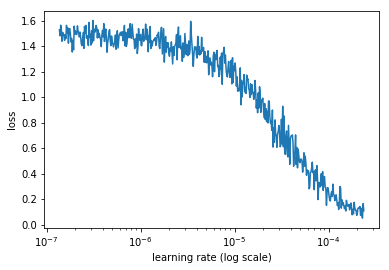

In [21]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

# Trash

In [ ]:
1/0
plt.hist(np.argmax(y_train, 1))